In [1]:
import pandas as pd
from typing import List, Tuple, Dict, Any
import numpy as np
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import os
import sys
import random
import matplotlib.pyplot as plt

In [2]:
dataset_name = "m4_hourly_miscellaneous"

In [3]:
input_fname = "m4_hourly_dataset.tsf"
output_dir = f'./../../processed/{dataset_name}/'
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')
outp_fig_fname = os.path.join(output_dir, f'{dataset_name}.png')

# Read Data

In [4]:
def data_line_generator(filepath: str):
    """
    Generator function that yields each line of data after the '@data' marker in the file.

    Args:
    filepath (str): The path to the file from which to read the data.

    Yields:
    str: The next line of data from the file.
    """
    with open(filepath, 'r') as file:
        # Iterate over the file until the '@data' marker is found
        for line in file:
            if line.strip() == "@data":
                break

        # Yield each line of data after the '@data' marker
        for line in file:
            if not line.strip():  # Skip any empty lines that may be present
                continue
            yield line.strip()

In [5]:
def generate_timestamps(start_timestamp_str: str, time_steps: int) -> List[str]:
    """
    Generates a list of hourly timestamps starting with the given timestamp and incrementing by 1 hour. 

    Args:
        start_timestamp_str (str): The starting timestamp in string format 'YYYY-MM-DD HH-MM-SS'.
        time_steps (int): The number of hourly time steps to generate.

    Returns:
        List[str]: A list of timestamps in string format incremented hourly.
    """
    # Convert the start timestamp string to a datetime object
    start_timestamp = datetime.strptime(start_timestamp_str, "%Y-%m-%d %H-%M-%S")
    
    # Generate a list of timestamps
    timestamps = [start_timestamp + timedelta(hours=i) for i in range(time_steps)]
    
    # Convert the timestamps back to strings
    timestamp_strs = [timestamp.strftime("%Y-%m-%d %H-%M-%S") for timestamp in timestamps]
    
    return timestamp_strs

# Test the function with a start timestamp and 5 time steps
test_timestamps = generate_timestamps("2010-05-01 14-00-00", 5)
test_timestamps

['2010-05-01 14-00-00',
 '2010-05-01 15-00-00',
 '2010-05-01 16-00-00',
 '2010-05-01 17-00-00',
 '2010-05-01 18-00-00']

# Find min and max length of series

In [6]:
data_gen = data_line_generator(input_fname)

def find_series_lengths_count(max_series=10000):
    series_lengths_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_length = len(fields[-1].split(","))
            if series_length not in series_lengths_dict:
                series_lengths_dict[series_length] = [series_name]
            else: 
                series_lengths_dict[series_length].append(series_name)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    return series_lengths_dict

series_lengths_dict = find_series_lengths_count(max_series=10000)

In [8]:
# Number of series
sum([len(s) for s in series_lengths_dict.values()])

414

In [9]:
# Find count of series per length 
len_counts = {k: len(v) for k, v in series_lengths_dict.items()}
len_counts

{748: 169, 1008: 245}

In [10]:
# We will sample from lengths of 748 because they look more like real-world series. Charting is below. 
# The series of length 1008 seem all synthetically generated. 
target_len = 748

# Process Full Data

In [11]:
data_gen = data_line_generator(input_fname)

def process_data(max_series):
    df_list = []
    timestamp_lookup_dict = {}
    for i in range(max_series):
        try:
            line = next(data_gen)
            fields = line.split(":")
            series_name = fields[0]
            series_start_datetime = fields[1]
            series_vals = fields[-1].split(",")
            num_time_steps = len(series_vals)
            
            # filter for target start year and num of years
            if num_time_steps != target_len:
                continue
                            
            epochs_list = np.arange(target_len)
            df = pd.DataFrame({'epoch': epochs_list})
            df['series'] = series_name
            df['value'] = series_vals
            df['value'] = df['value'].astype(float)
            df_list.append(df)
        except StopIteration: 
            break
        except Exception as e:
            # If any other exception occurs, print the error and the problematic line
            print("An error occurred:", e)
            print("Problematic line:", line)
    all_data = pd.concat(df_list)
    return all_data
        
all_data = process_data(max_series=10000)
print(all_data.head())
print(all_data.shape)

   epoch series  value
0      0     T1  605.0
1      1     T1  586.0
2      2     T1  586.0
3      3     T1  559.0
4      4     T1  511.0
(126412, 3)


# Sample 35 Series

In [13]:
random.seed(0)
sampled_series = random.sample(series_lengths_dict[target_len], 35)
print(len(sampled_series))
print(sampled_series)

35
['T99', 'T108', 'T11', 'T67', 'T131', 'T125', 'T104', 'T78', 'T123', 'T92', 'T150', 'T56', 'T130', 'T36', 'T73', 'T156', 'T25', 'T65', 'T137', 'T38', 'T80', 'T26', 'T19', 'T85', 'T121', 'T144', 'T148', 'T91', 'T112', 'T81', 'T53', 'T161', 'T114', 'T134', 'T166']


# Filter Data

In [14]:
# Filter to the sample
final_data = all_data[all_data['series'].isin(sampled_series)].reset_index(drop=True)

In [15]:
print(final_data.shape)
final_data.head()

(26180, 3)


,epoch,series,value
0,0,T11,41889.0
1,1,T11,41145.0
2,2,T11,40629.0
3,3,T11,40281.0
4,4,T11,39751.0


In [17]:
series_col = "series"
epoch_col = 'epoch'
time_col=None
value_col = 'value'
exog_cols = []

# Visualize

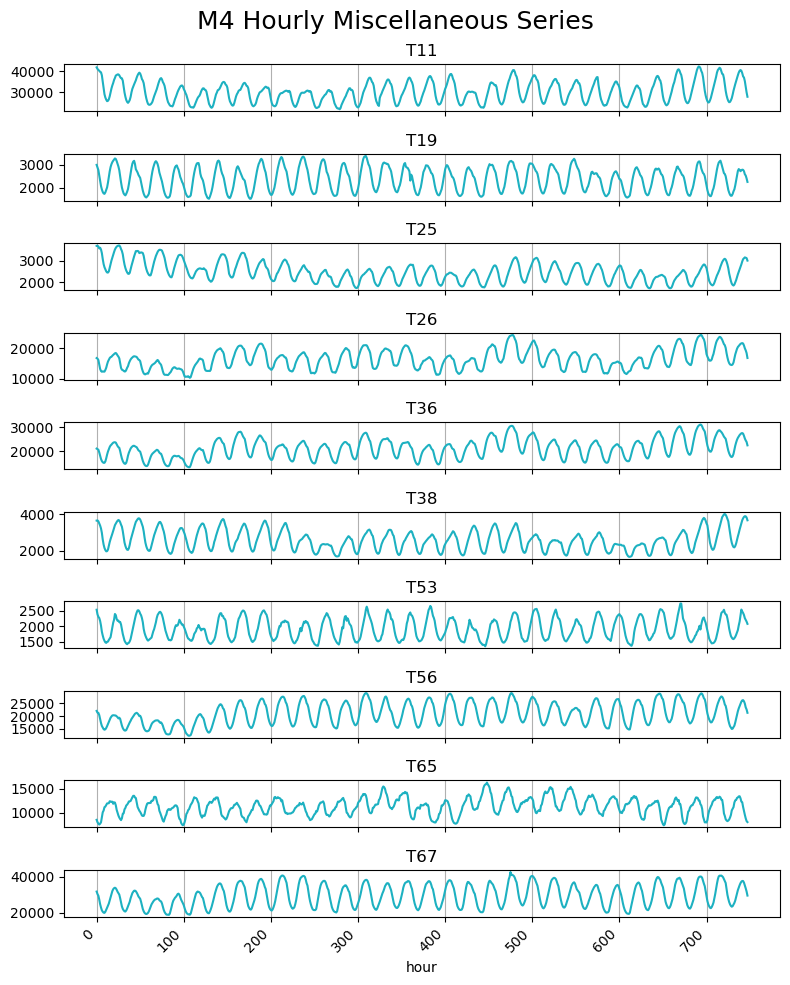

In [18]:
import matplotlib.pyplot as plt

def plot_trends(df, series_col, val_col, epoch_col, epoch_label, num_series=10,
                filepath=outp_fig_fname, chart_title=dataset_name):
    """
    This function takes a dataframe and a number of series to chart.
    It creates a n x 1 subplot (with n being the number of series, at most 10) and plots those series.
    
    Parameters:
    df (DataFrame): dataframe.
    num_series (int): The number of series to plot, defaulted to 10.
    """
    
    # Get the unique series from the dataframe
    unique_series = df[series_col].unique()
    
    # Limit the number of series to plot
    series_to_plot = unique_series[:min(len(unique_series), num_series)]
    
    # Set up the subplots
    fig, axes = plt.subplots(nrows=min(num_series, len(series_to_plot)), ncols=1, figsize=(8, num_series*1))
    
    # If there's only one series to plot, axes will not be an array, so we wrap it in a list
    if num_series == 1:
        axes = [axes]
    
    # Define the color for the plots
    plot_color = '#1db1c1'
    
    # Plot each series on a separate subplot
    for i, (ax, series_id) in enumerate(zip(axes, series_to_plot)):
        # Filter the dataframe for the current series
        series_data = df[df[series_col] == series_id]
                
        # Plot the data
        ax.plot(series_data[epoch_col], series_data[val_col], color=plot_color)
        
        # Set the title and labels
        ax.set_title(series_id)
        # ax.set_ylabel('Trend')
        # Show x-axis grid
        ax.xaxis.grid(True)
        
        # Show x-axis labels only for the last (bottom) plot
        if i < len(series_to_plot) - 1:
            ax.set_xticklabels([])
        else:
            # Rotate date labels to avoid overlap
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
            ax.set_xlabel(epoch_label)            
        
        # Rotate date labels to avoid overlap
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.suptitle(chart_title, fontsize=18)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save figure
    plt.savefig(filepath)
    
    plt.show()

# Plot a few series
plot_trends(
    final_data,
    series_col=series_col,
    val_col=value_col,
    epoch_col=epoch_col,
    epoch_label='hour',
    num_series=10,
    filepath=outp_fig_fname,
    chart_title="M4 Hourly Miscellaneous Series"
)  


# Save Main Data File

In [19]:
if time_col: 
    all_cols = [series_col, time_col, value_col] + exog_cols
else: 
    all_cols = [series_col, value_col] + exog_cols

final_data.sort_values(by=[series_col, epoch_col], inplace=True)

final_data[all_cols].to_csv(outp_fname, index=False)